# Defs and loads

In [59]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import partridge as ptg
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

parent = Path('..','data')
dynamic_path = parent / 'dynamic_gtfs'
static_path = parent / 'static_gtfs'

In [60]:
train_day = '20251010'
test_day = '20251011'

df_train = pd.read_csv(dynamic_path / 'delays' / f'{train_day}.csv',header=0)
df_test  = pd.read_csv(dynamic_path / 'delays' / f'{test_day}.csv',header=0)

len(df_train), len(df_test)

(24336, 9115)

In [61]:
display(df_train.loc[df_train['delay'].idxmin()])
display(df_train.loc[df_train['delay'].idxmax()])

route_id            1660
trip_id       D020722246
delay               -891
trip_start         59280
Name: 16230, dtype: object

route_id             2100
trip_id       D0345812379
delay                 899
trip_start          54540
Name: 19666, dtype: object

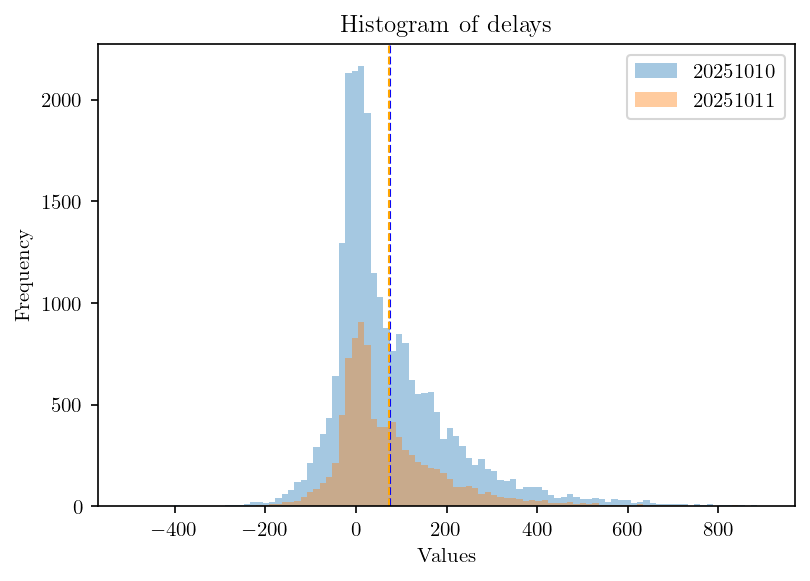

In [63]:
plt.figure(figsize=(6,4),dpi=150)

plt.hist(df_train["delay"], bins=100, range=(-500, 900),alpha=0.4, label=train_day)
plt.hist(df_test["delay"], bins=100, range=(-500, 900),alpha=0.4, label=test_day)

plt.axvline(df_train["delay"].mean(), color="blue", linestyle="--", linewidth=1)
plt.axvline(df_test["delay"].mean(),  color="orange", linestyle="--", linewidth=1)

plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title(f"Histogram of delays")
plt.legend()
plt.show()

In [64]:
# MODELS
class PeriodRouteModel:

    """
    A napszak és a route figyelembevételével becsül átlag késést
    """
    
    def __init__(self, bins):
        self.labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]
        self.bins = [b*60*60 for b in bins]

    def fit(self,df):
        df = df.copy()
        df["period"] = pd.cut(df['trip_start'],bins=self.bins,labels=self.labels)

        self.model = (
            df.groupby(["period", "route_id"], observed=False)["delay"]
            .mean()
            .dropna()
            .to_dict()
        )
    
    def evaluate(self,df):
        df = df.copy()
        df["period"] = pd.cut(df['trip_start'],bins=self.bins,labels=self.labels)

        df["pred_delay"] = df.apply(
            lambda r: self.model.get((r["period"], r["route_id"])),
            axis=1
        ).fillna(0)

        rmse = np.sqrt(mean_squared_error(df["delay"], df["pred_delay"]))
        mae = mean_absolute_error(df["delay"], df["pred_delay"])

        return rmse, mae


class RouteModel:
    
    """
    A route figyelembevételével becsül átlag késést
    """

    def __init__(self):
        pass

    def fit(self,df):
        df = df.copy()
        self.model = (
            df.groupby(["route_id"], observed=False)["delay"]
            .mean()
            .dropna()
            .to_dict()
        )
    
    def evaluate(self,df):
        df = df.copy()
        df["pred_delay"] = df.apply(
            lambda r: self.model.get(r["route_id"]),
            axis=1
        ).fillna(0)

        rmse = np.sqrt(mean_squared_error(df["delay"], df["pred_delay"]))
        mae = mean_absolute_error(df["delay"], df["pred_delay"])

        return rmse, mae

In [68]:
model = PeriodRouteModel(bins=[0,6,9,15,18,24])
model.fit(df_train)
model.evaluate(df_test)

(123.52797191358891, 87.06039775758472)

In [69]:
model = PeriodRouteModel(bins=[0,8,16,24])
model.fit(df_train)
model.evaluate(df_test)

(124.61383528654501, 88.41102996881226)

In [70]:
model = RouteModel()
model.fit(df_train)
model.evaluate(df_test)

(125.59899235345281, 88.8458518947327)